#### Shapley value example

Lets start by importing the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from itertools import combinations

%matplotlib inline

We will be using the marketing.csv dataset from the book's github repository. Lets import in into a dataframe a have a look at it:


In [3]:
data = pd.read_csv('../data/marketing.csv')
data.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,NaN,House Ads,True
1,a100000030,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,NaN,House Ads,True
2,a100000031,1/1/18,House Ads,personalization,True,English,English,24-30 years,1/1/18,NaN,House Ads,True
3,a100000032,1/1/18,House Ads,personalization,True,English,English,30-36 years,1/1/18,NaN,House Ads,True
4,a100000033,1/1/18,House Ads,personalization,True,English,English,36-45 years,1/1/18,NaN,House Ads,True


As we can see from the table, we have user level data for which marketing channel they were exposed to and whether they converted or not. We also have the date when they were exposed to the marketing channel.
For this exercise we will only need the user_id, the date_served, the marketing_channel and the converted columns. Lets create a new dataframe with only those columns:

In [3]:
data = data[['user_id', 'date_served', 'marketing_channel', 'converted']]
data.dropna(axis = 0, inplace=True)
data['converted'] = data['converted'].astype('int')
data['date_served'] = pd.to_datetime(data['date_served'], format='%m/%d/%y', errors='coerce')
data.head()

,user_id,date_served,marketing_channel,converted
0,a100000029,2018-01-01,House Ads,1
1,a100000030,2018-01-01,House Ads,1
2,a100000031,2018-01-01,House Ads,1
3,a100000032,2018-01-01,House Ads,1
4,a100000033,2018-01-01,House Ads,1


Now we need to create the dataframe with the coalitions, which in this case are the paths to conversion. We will use the date_served column to order the dataframe and then we will group by user_id and marketing_channel to create the paths to conversion:

In [4]:
ordered_data = data[['user_id', 'marketing_channel', 'converted']].sort_values(by=['user_id', 'marketing_channel'])

grouped = ordered_data.groupby(['user_id'], as_index=False).agg({
    'marketing_channel': lambda x: ','.join(sorted(x.unique())),
    'converted': 'max'
})
grouped.rename(columns={
    'marketing_channel': 'marketing_channel_subset'
}, inplace = True)

coalitions = grouped.groupby(['marketing_channel_subset'], as_index=False).agg({
    'converted': 'sum'
})

We essencially doing the following:
- Selecting and Sorting: We are selecting the user_id, marketing_channel and converted columns from the df dataframe, and sorting by user_id and marketing_channel
- Grouping and Aggregating on a per-user basis: We are grouping by user_id and marketing_channel and aggregating the converted column with the max function. We then rename the marketing_channel column for clarity.
- Grouping and Aggregating based on marketing channel combinations: We simply group by marketing_channel_subset and sum the converted column to get the number of conversions for each path to conversion.

Lets have a look at the paths to conversion dataframe:

In [5]:
coalitions

,marketing_channel_subset,converted
0,Email,110
1,"Email,Facebook",11
2,"Email,Facebook,House Ads",8
3,"Email,Facebook,House Ads,Instagram",0
4,"Email,House Ads",40
5,"Email,House Ads,Instagram",3
6,"Email,House Ads,Push",1
7,"Email,Instagram",10
8,"Email,Push",4
9,Facebook,103


For the Shapley value calculation we will need a few auxiliary functions. Lets start by creating a function that return us the Power Set of all the sets, in this case the marketing channels. Essencially we want all possible combinations of marketing channels:

In [6]:
# Create a function that returns all possible combinations of the channel
def power_set(sets: list) -> list:
    return [list(j) for i in range(len(sets)) for j in combinations(sets, i+1)]

Then we need to create a function to calculate all the possible subsets of a set of channels:

In [7]:
def subsets(channels):
    '''
    Returns all possible subsets of a set of channels
    '''
    if len(channels) == 1:
        return channels
    else:
        sub_channels = []
        for i in range(1, len(channels) + 1):
            sub_channels.extend(map(list, combinations(channels, i)))
    return list(map(','.join,map(sorted, sub_channels)))

Next comes the caracteristic function $v(s)$, which we will use to measure each coalition. It takes a list of channels, i.e., the coalition, a dict of the conversions per channel:

In [8]:
# caracteristic function v(s)

def v_function(coalition: list, conversions: dict) -> int:
    subsets_coalition = subsets(coalition)
    worth_coalition = 0
    for subset in subsets_coalition:
        if subset in conversions:
            worth_coalition += conversions[subset]
    
    return worth_coalition


Finally a simple function to calculate the factorial of a number:

In [15]:
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n - 1)

We now have all the necessary functions to calculate the Shapley values. The function to calculate them is as follows:

In [10]:
def calculate_shapley_values(data: pd.DataFrame, channel_name: str, conv_name: str) -> defaultdict:
    conversion_values = data.set_index(channel_name).to_dict()[conv_name]
    data['channels'] = data[channel_name].apply(lambda x: x if len(x.split(',')) == 1 else np.nan)
    channels = list(data['channels'].dropna().unique())

    v_values = {}

    for A in power_set(channels):
        v_values[','.join(sorted(A))] = v_function(A, conversion_values)

    n = len(channels)
    shapley_values = defaultdict(int)
    
    for channel in channels:
        for A in v_values.keys():
            if channel not in A.split(","):
                cardinal_A = len(A.split(","))
                A_with_channel = A.split(",")
                A_with_channel.append(channel)
                A_with_channel = ",".join(sorted(A_with_channel))
                # Weight = |S|!(n - S - 1)! / n!
                weight = (factorial(cardinal_A) * factorial(n - cardinal_A - 1) / factorial(n))
                # Marginal contrib = v(S U {i} - v(S))
                contrib = (v_values[A_with_channel] - v_values[A])
                shapley_values[channel] += weight * contrib
        shapley_values[channel] += v_values[channel] / n
        
    return shapley_values

Now, since this function looks a bit complicated, lets break it a apart and see what each part does:
1. **Input Parameters**:
   - `data`: A pandas DataFrame containing information about conversions for different marketing channel combinations.
   - `channel_name`: The column name in `data` that has the marketing channel names or combinations.
   - `conv_name`: The column name in `data` that contains the conversion values.

2. **Conversion Values Dictionary**:
   ```python
   conversion_values = data.set_index(channel_name).to_dict()[conv_name]
   ```
   This creates a dictionary where keys are marketing channel combinations and values are conversions.

3. **Single Channels Extraction**:
   ```python
   data['channels'] = data[channel_name].apply(lambda x: x if len(x.split(',')) == 1 else np.nan)
   channels = list(data['channels'].dropna().unique())
   ```
   This filters the DataFrame to only consider individual channels (and not combinations). These individual channels are stored in the list `channels`.

4. **V-Function Values Calculation**:
   ```python
   for A in power_set(channels):
       v_values[','.join(sorted(A))] = v_function(A, conversion_values)
   ```
   For every possible subset of channels (obtained using `power_set`), the function calculates its value using the `v_function` and stores it in the `v_values` dictionary.

5. **Initialization**:
   ```python
   n = len(channels)
   shapley_values = defaultdict(int)
   ```
   - `n` captures the total number of individual channels.
   - `shapley_values` will store the computed Shapley values for each channel.

6. **Shapley Values Calculation**:
   The nested for-loop is doing the heavy lifting of calculation. The Shapley value for a player (here, a channel) is the average marginal contribution of the player across all possible coalitions. The nested for-loop ensures each coalition and each channel are considered.

7. **Return**:
   ```python
   return shapley_values
   ```
   Finally, the function returns the computed Shapley values for each channel in the form of a dictionary.

Lets get the results into a variable, and create a dataframe with it, so we can have a look at the results:

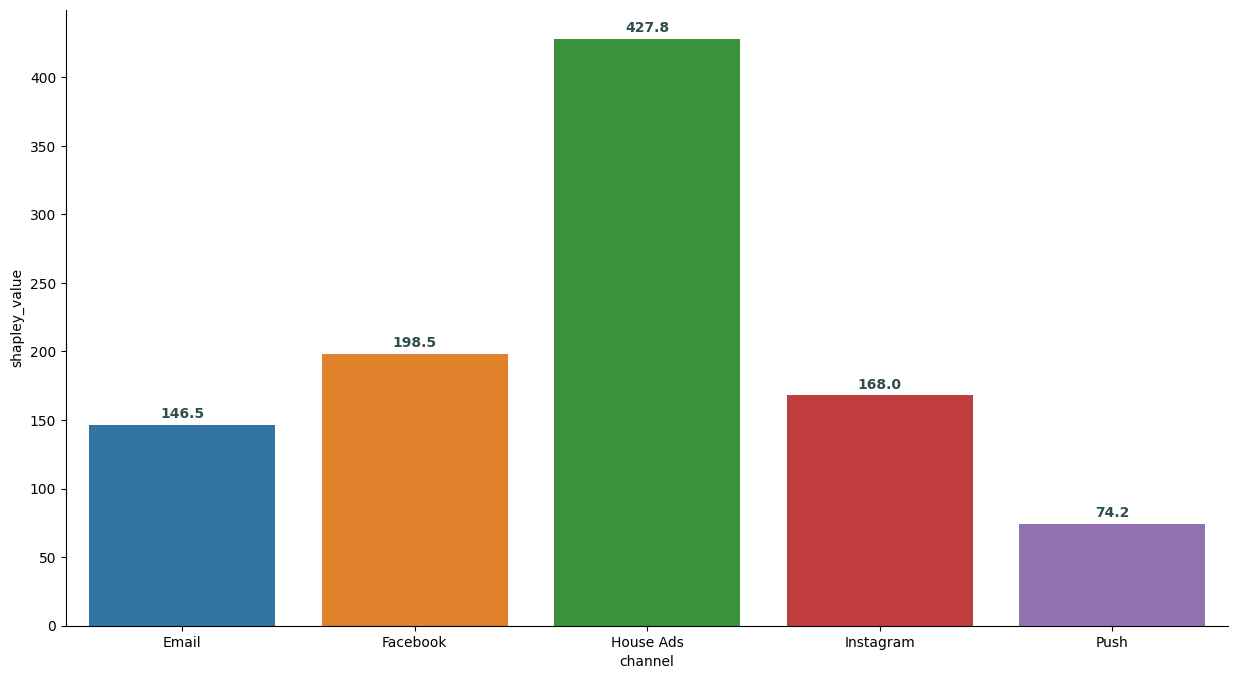

In [16]:
shapley_values = calculate_shapley_values(coalitions, 'marketing_channel_subset', 'converted')
shapley_result = pd.DataFrame(list(shapley_values.items()), columns=['channel', 'shapley_value'])
plt.subplots(figsize=(15,8))
s = sns.barplot(x = 'channel', y = 'shapley_value', data = shapley_result)
sns.despine(top=True, right=True)
for idx, row in shapley_result.iterrows():
    s.text(row.name, row.shapley_value +5, round(row.shapley_value,1), ha='center', color='darkslategray', fontweight='semibold')
plt.show();